In [105]:
# Initialize Otter
import otter
grader = otter.Notebook("projA2.ipynb")

# Project A2: Predicting Housing Prices in Cook County

## Due Date: Thursday, October 26th, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, October 26th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *Jordan Wolf*

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mid-semester survey

Please fill out the mid-semester survey [here](https://forms.gle/XJbuiDryUsGXgdrN7). We appreciate your feedback! 

Note: The public test only checks if you enter the password in the correct format.

In [129]:
qsurvey = "9O8I7U6Y5T4R3E2W1Q"

In [130]:
grader.check("qsurvey")

qsurvey results: All test cases passed!



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

In project A1, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, you will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project, and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `scikit-learn` to build and fit linear models.

## Score Breakdown

Question | Manual | Points
----|----|----
Survey | No | 1
1a | Yes | 1
1b | Yes | 1
1c | No | 1
1d | Yes | 1
1e | Yes | 1
2 | No | 2
3a | No | 2
3b | No | 3
3c | No | 2
4a | Yes | 2
4b | No | 1
5a | No | 0
5b | No | 0
5c | No | 0
5d | No | 3
5e | No | 0
5f | No | 0
5g | No | 0
6a | No | 1
6b | No | 2
6c | Yes | 2
7a | Yes | 1
7b | Yes | 2
Test Prediction | No | 3
Total | 8 | 32

In [108]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test
from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load training, validation, and test data.

In [109]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, you will train a model on the training/validation set then use this model to predict the `Sale Price`s of the test set. In the cell below, we load the training/validation set into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [110]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [111]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook. 

In [112]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset. **You should watch Lecture 15 before attempting this part.**

<br>

--- 

### Question 1a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**

House owners, Real Estate agents, government agencies

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

All Scenarios are unfair. 
A. The homeowner may have to pay higher taxes
B. unfair by other homeowners who are paying higher taxes relative to their home's actual value. Additionally, if many homes are undervalued, it could result in insufficient funding for local service
c.This is unfair because it places a disproportionate tax burden on owners of inexpensive homes while giving a break to those with more expensive properties.
D.distorts the tax base and doesn't accurately reflect the true value of properties.

<!-- END QUESTION -->

<br>

---

### Question 1c

Consider a model that is fit to $n = 50$ training observations. We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual to be $y - \hat{y}$. Which residual plot corresponds to a model that might make property assessments that result in regressive taxation? Recall from Lecture 15 that regressive taxation overvalues inexpensive properties and undervalues expensive properties. Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q1c` to the string letter corresponding to your plot choice.

**Hint:** When a model overvalues a property (predicts a `Sale Price` greater than the actual `Sale Price`), what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

<img src='images/res_plots.png' width="900px" />

In [133]:
q1c = 'a'

In [134]:
grader.check("q1c")

q1c results: All test cases passed!

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Make sure to watch Lecture 15 before answering the following questions!

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune? What were the primary causes of these problems? (Note: In addition to reading the paragraph above you will need to watch the lecture to answer this question)

 One of the central problems was the racially biased assessments that disproportionately affected certain communities. The system consistently undervalued high-priced homes while overvaluing low-priced homes. This disparity created a clear racial divide, where wealthier, predominantly white homeowners were under-assessed, leading to lower tax contributions, while working-class, non-white homeowners faced inflated assessments and consequently, higher taxes.

Some primary Causes of the problems were segregation and credit market racism Segregation was not only a result of federal policy, but developed by real estate professionals Real estate industry “professionalized” in the 1920’s and 1930’s by aspiring to become a science guided by strict methods and principles.These methods centered on creating objective rating systems (information technologies) for the appraisal of property values which encoded race as a factor of valuation and which, in turn, influenced federal policy and practice

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The system's inaccurate assessments meant that these homeowners were consistently paying a larger percentage of their property's actual value in taxes than their wealthier, often white, counterparts. When these inaccurate valuations were combined with the economic realities of racial wealth gaps, the effect was even more pronounced. Non-white homeowners were not only paying disproportionately high taxes but were also doing so with a generally lower economic base. The property tax system did so by  making it difficult or impossible to get a federally-backed mortgage to buy a house in specific neighborhoods coded as “risky” (red)

<!-- END QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Preparing Data


Let's split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20%. You should not be importing any additional libraries for this question. Your answer should use the variable `shuffled_indices` defined for you. Take a look at the `np.permutation` [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html). You should only be using `NumPy` functions to generate randomness!

**Hint:** While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 80% and 20% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` `DataFrame`s. To ensure that your code matches our solution, use the first 80% as the training set and the last 20% as the validation set. Remember, the values you use to partition `data` must be integers!

*The provided tests check that you not only answered correctly but ended up with the same train/validation split as our reference implementation. Later testing is easier this way.*

In [115]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    
    train_indices_len= int(data_len*0.8)
    train_indices=shuffled_indices[:train_indices_len]
    validation_indices = shuffled_indices[ train_indices_len:]
    
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [116]:
grader.check("q2")

q2 results: All test cases passed!

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting a Simple Model

Let's fit our linear regression model using the ordinary least squares estimator! We will start with something simple by using only two features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

--- 

## Question 3a

**Without running any calculation or code**, assign `q3a` to be the comparator ('>=', '=', '<=') that fills the blank in the following statement:

We quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$

In [117]:
q3a = ">="

In [118]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

### Pipeline function

In Project A1, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs `X` and `Y` for the first model above. Try to understand what this function does! 

**Note:** We have automatically imported staff implementations of the functions you wrote in Project A1. These functions are `remove_outliers`, `add_total_bedrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_roof_material`. You are welcome to copy over your own implementations if you like.

In [119]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `process_data_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [120]:
# Run this cell to define process_data_pipe; no further action is needed.
def process_data_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

<br>

--- 

## Question 3b

It is time to prepare the training and validation data for the two models we proposed above. Use the following two cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `process_data_pipe` for each model:

- Perform a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` so that we consider households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` if this is the 2nd model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should be `NumPy` arrays or `pandas` DataFrames**.

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`. This is already implemented for you. 
- 2nd Model: `X_train_m2`, `Y_train_m2`, `X_valid_m2`, `Y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

For an example of how to work with pipelines, we have processed m1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples in the below cell. Your task is to do the same for model 2 in the cell after - that is, save your pipelines functions as a list of tuples and assign it to `m2_pipelines` for model 2.

As a refresher, the equations model 1 and model 2, respectively, can be found below:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset the same way for both models (otherwise, their performance isn't directly comparable).

In [121]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [122]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Building Square Feet', 'Bedrooms', "Log Sale Price"], None)
]

X_train_m2, Y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,Log Building Square Feet,Bedrooms
130829,7.870166,4
193890,7.002156,2
30507,6.851185,2
91308,7.228388,2
131132,7.990915,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [123]:
grader.check("q3b")

q3b results: All test cases passed!

<br>

--- 

## Question 3c

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [124]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- 1st Model: predicted values on **training set**: `Y_fitted_m1`, predicted values on **validation set**: `Y_predicted_m1`
- 2nd Model: predicted values on **training set**: `Y_fitted_m2`, predicted values on **validation set**: `Y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and validation data set, there won't be any hidden tests for this part.

In [125]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)

# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [126]:
grader.check("q3c")

q3c results: All test cases passed!

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 4: Evaluate Our Simple Model

<br>

--- 

We are moving into the analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

The function is provided below.

In [127]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br>

--- 

## Question 4a

One way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.

In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With such a large dataset, it is difficult to avoid overplotting entirely. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

Text(0.5, 1.0, 'residuals vs Original Log Sale Price')

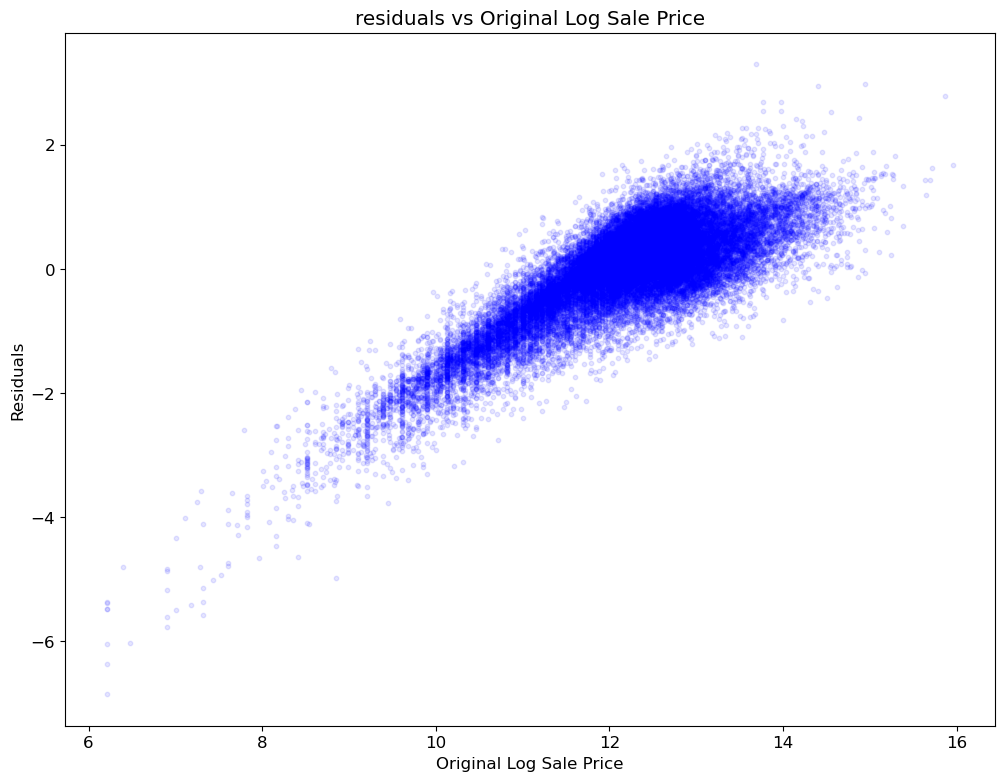

In [128]:
residuals_m2= Y_valid_m2-Y_predicted_m2
plt.scatter(Y_valid_m2,residuals_m2, alpha=0.1,s=10,c="b",label="Residuals")
plt.xlabel("Original Log Sale Price")
plt.ylabel("Residuals")
plt.title("residuals vs Original Log Sale Price")

<!-- END QUESTION -->

<br>

--- 

## Question 4b

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign "regressive", "fair" or "progressive" to `q4b` in the cell below accordingly.


In [102]:
q4b = "Regressive"

In [103]:
grader.check("q4b")

q4b results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incorporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part of this project.

<br>

<hr style="border: 1px solid #fdb515;" />

# Question 5

It is time to build your own model!

You will process training data using your `process_data_final` function (you will define this in 5e), fit the model with this training data, and compute the training RMSE. Then, we will process test data with your `process_data_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

Your goal in Question 5 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling.
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house – your model is trying to guess them! 
* Submit your predicted `Log Sale Price`s on the test set to Gradescope.


Right under the grading scheme, we will outline some important DataHub logistics. **Please make sure you read this carefully to avoid running into memory issues later!**

* In Question 5a, you can explore possible features for your model. Note that this portion is not graded.
* In Question 5b, you can perform EDA on the dataset. Note that this portion is not graded.
* In Question 5c, you can define feature engineering helper functions. Note that this portion is not graded.
* In Question 5d, you will create your design matrix and train a model.
* In Question 5e, you can fit and evaluate your model. Note that this portion is not graded.
* In Question 5f, you will generate the predictions for the test set.

### Grading Scheme

Your grade for Question 5 will be based on your model's RMSE when making predictions on the training set, as well as your model’s RMSE when making predictions on the test set. The tables below provide scoring guidelines. If your RMSE lies in a particular range, you will receive the number of points associated with that range.

**Important**: while your training RMSE can be checked at any time in this notebook, your test RMSE can only be checked by submitting your model’s predictions to Gradescope. **You only have 21 attempts to submit your predictions to Gradescope**. How you choose to use your submissions is up to you. However, we recommend planning ahead to make sure you have enough time to finetune your model! The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k

make a scatter plot and find a correlation to find the features. 
apply transformations call from A1\

<br><br>

---
## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed independently code-wise from the remainder of the project, and you do not need to rerun the cell at the top of this notebook. The autograder will have more than 4GB of memory, so you will not lose credit as long as your solution to Question 5 is within the total memory (4GB) limits of DataHub. By default, we reset the memory and clear all variables using `%reset -f`. If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- **Note: If you need the data again after deleting the variables or resetting, you must reload them again.**
- You will be predicting `Log Sale Price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)
- You MUST remove any additional new cells you add before submitting to Gradescope to avoid any autograder errors. 
- **You can only submit the CSV file to Gradescope up to a total of 21 times in order to meet the threshold**. You may either space them out throughout the week or use them all in one day, but we highly recommend spacing them out. **Start early!** In the case that you are approved for an extension, you are granted 3 more submissions for each day the deadline has been extended. 

**PLEASE READ THE ABOVE MESSAGE CAREFULLY!**

In [42]:
# The 3 lines below to clean up memory from previous questions and reinitialize Otter!
# If you want to refer to any functions or variables you defined at any point earlier in the project, 
# Place them in the cell under Question 5c so that you can access them after the memory is reset
# If you think you will not run into any memory issues, you are free to comment out the next 3 lines as well.

%reset -f                               
import otter                            
grader = otter.Notebook("projA2.ipynb")

# Imports all the necessary libraries again

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br>

---

## Question 5a: Finding Potential Features

**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in `5d`. You may write as little or as much as you would like here; it will not factor into your grade. Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think may be related to housing prices? Drop them down below for your later reference.

_Type your answer here, replacing this text._

Building Square Feet
Age
Garage Indicator 
Central Air 


<br>

---

## Question 5b: More EDA


**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering. You may write as little or as much as you would like here; it will not factor into your grade. Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between any variables or compute any relevant statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review Project A1 and the techniques we explore there.


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers? This can inform how you engineer your features later

* Make a scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

<br>

---

## Question 5c: Defining Helper Function or Helper Variables

**This question is not graded but we suggest that you put all your helper functions below for readability and ease of testing.** Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [ ]:
# Define any additional helper functions or variables you need here

<br>

---

## Question 5d: Defining Pipeline Funtion

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `process_data_final` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it! **You must not change the parameters inside `process_data_final`. Do not edit the two lines at the end of the question cell below. They are helper functions that define a linear model, fit your data, and compute RMSE. If you do, you will receive no credit for this question.** 

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

**Hints:**
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `process_data_final` handles missing values appropriately for each feature.
- We have imported all feature engineering functions from Project A1 for you. You do not have access to the `feature_func.py` file with the function body and definitions, but they work as defined in Project A1. Feel free to use them as you see fit!
- You may wish to consider removing outlying data points from the training set before fitting your model. You may not, however, remove any data points from the test set (the CCAO could not simply "refuse" to make predictions for a particular house!)
- As you finetune your model, you may unintentionally consume too much DataHub memory, causing your kernel to crash. See Question `5a` for guidance on how to resolve this!!

In [80]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        data["Log Sale Price"]=np.log(data["Sale Price"])
        data=remove_outliers(data, "Sale Price", lower=1000, upper= 1500000)
        
        data=data[data["Estimate (Building)"]!=0]
        avg_building_estimate= data["Estimate (Building)"].mean()
        data["Estimate (Building)"]=data["Estimate (Building)"].replace(0,avg_building_estimate)
        data["Log Estimate Building"]=np.log(data["Estimate (Building)"])
        data["Log Building Square Feet"]=np.log(data["Building Square Feet"])
        
        data=select_columns(data,'Log Building Square Feet',"Log Estimate Building", "Log Sale Price", "Age", "Central Air","Garage Indicator")
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
    else:
        avg_building_estimate= data["Estimate (Building)"].mean()
        data["Estimate (Building)"]=data["Estimate (Building)"].replace(0,avg_building_estimate)
        data["Log Estimate Building"]=np.log(data["Estimate (Building)"])
        data["Log Building Square Feet"]=np.log(data["Building Square Feet"])
    
        data=select_columns(data,'Log Building Square Feet',"Log Estimate Building", "Age", "Central Air","Garage Indicator")
        
    


        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    
    
        
    
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = data[['Log Building Square Feet',"Log Estimate Building", "Age", "Central Air","Garage Indicator"]]
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        #X = data['Log Building Square Feet',"Log Estimate Building", "Age", "Central Air","Garage Indicator"]
        X=data.drop(["Log Sale Price"],axis=1)
        # Response variable
        #Y = data["Log Sale Price"]
        Y=data.loc[:, "Log Sale Price"]
        return X, Y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Q5")

Current training RMSE: 137980.6036599966
You can check your grade for your prediction as per the grading scheme outlined at the start of Q5


In [81]:
grader.check("q5d")

q5d results: All test cases passed!

<br>

---

## Question 5e: Fit and Evaluate your Model

**This question is not graded.** Use this space below to evaluate your models. Some ideas are listed below. 

**Note:** While we have a grader function that checks RMSE for you, it is best to define and create your own model object and fit on your data. This way, you have access to the model directly to help you evaluate/debug if needed. For this project, you should use a `sklearn` default `LinearRegression()` model with intercept term for grading purposes. Do not modify any hyperparameter in `LinearRegression()`, and focus on feature selection or hyperparameters of your own feature engineering function.


<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your RMSE. Is this a reasonable number? You may use our grading scheme as a reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the beginning of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets come from the same population (recall that test and training/validation sets are a random split from larger data), we expect our test prediction to have a similar range as the validation data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform cross-validation to estimate your test error. Recall that we are treating the validation set as unseen data.
    
</details>

In [ ]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again

<br>

---

## Question 5f Submission

Recall that the test set given to you in this assignment does not contain values for the true `Sale Price` of each house. To determine your model's RMSE on the test set, you will submit the predictions made by your model to Gradescope. There, we will run checks to see what your test RMSE is by considering (hidden) true values for the `Sale Price`.
Your score on this section will be determined by the grading scheme outlined at the start of Question 5. Remember that you can only submit test predictions to Gradescope 21 times in total. Plan your time to ensure that you can adjust your model as necessary.

To determine the error on the test set, please submit your predictions on the contest test set to the Gradescope assignment: **Project A2 Test Set Predictions**. The CSV file to submit is generated below and you should not modify the cell below. Simply download the CSV file and submit it to the appropriate Gradescope assignment.

Note that **you will not receive credit for the test set predictions (i.e., up to 3 points) unless you submit to this assignment**!!

In [82]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

You may now upload this CSV file to Gradescope for scoring.


In [ ]:
# Scratch space to check if your prediction is reasonable. See 5e for hints. 
# We will not reset the submission count for mis-submission issues.
submission_df["Value"].describe()

Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study - especially because statistical modeling is how the CCAO valuates properties. 

Refer to Lecture 15 if you're having trouble getting started!

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 6: Exploring RMSE

Let's delve a bit deeper into what RMSE means in the context of predicting house prices. We will go through different ways of visualizing the performance of the model you created and see how that ties into questions about property taxes.

<br>

---

In [83]:
# Run the cell below; no further action is needed
train_df = pd.read_csv('cook_county_train.csv')
X, Y = process_data_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y)
Y_pred = model.predict(X)

<br>

---
### Question 6a

Let's examine how our model performs on two subsets of our data - `Y_small` being `Log Sale Price`s in the interval (8, 11) and `Y_big` being `Log Sale Price`s in the interval (11, 14). In terms of `Sale Price`, this roughly translates to the intervals (3000, 60000) and (60000, 1000000), respectively.

In [84]:
# Run the cell below to obtain the two subsets of data; no further action is needed.
small_interval = (8, 11)
big_interval = (11, 14)
Y = pd.DataFrame(Y)
Y_small = Y[(Y['Log Sale Price'] > small_interval[0]) & (Y['Log Sale Price'] < small_interval[1])]['Log Sale Price']
Y_big = Y[(Y['Log Sale Price'] > big_interval[0]) & (Y['Log Sale Price'] < big_interval[1])]['Log Sale Price']
X_small = X.loc[Y_small.index]
X_big = X.loc[Y_big.index]

**Compute the RMSE of your model's predictions on each subset separately** and assign those values to `rmse_small` and `rmse_big` respectively. Here, we are asking for your RMSE **with regard to `Sale Price`**. Remember to exponentiate your predictions and response vectors before computing the RMSE using the `rmse` function defined earlier!

Separately, we also want to understand whether the proportion of houses in each interval that the model overestimates the value of the actual `Sale Price`. To that end, **compute the proportion of predictions strictly greater than the corresponding true price in each subset** and assign it to `prop_overest_small` and `prop_overest_big` respectively. For example, if we were working with a dataset of 3 houses wherein the actual `Log Sale Price`s were [10, 11, 12] and the model predictions were [5, 15, 13], then the proportion of houses with overestimated values would be 2/3.  

**Note:** Reflect on whether you need to transform the predictions for the second task. Does the proportion change when you exponentiate the values and perform the comparisons of true and predicted values?

In [101]:
rmse_small = rmse(np.exp(Y_small), np.exp(model.predict(X_small)))
rmse_big = rmse(np.exp(Y_big), np.exp(model.predict(X_big)))

prop_overest_small =  np.mean(model.predict(X_small) > Y_small)
prop_overest_big = np.mean(model.predict(X_big) > Y_big)

print(f"The RMSE for properties with log sale prices in the interval {small_interval} is {np.round(rmse_small)}")
print(f"The RMSE for properties with log sale prices in the interval {big_interval} is {np.round(rmse_big)}")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {small_interval} is {100 * np.round(prop_overest_small, 3)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {big_interval} is {100 * np.round(prop_overest_big, 3)}%")

The RMSE for properties with log sale prices in the interval (8, 11) is 68247.0
The RMSE for properties with log sale prices in the interval (11, 14) is 132715.0
The percentage of overestimated values for properties with log sale prices in the interval (8, 11) is 95.8%
The percentage of overestimated values for properties with log sale prices in the interval (11, 14) is 36.7%


In [92]:
grader.check("q6a")

q6a results: All test cases passed!

<br>

---
### Question 6b

The intervals we defined above were rather broadly defined. Let's try and take a more fine-grained approach to understand how RMSE and proportion of houses overestimated vary across different intervals of `Log Sale Price`. To that end, complete the definition of the functions `rmse_interval` and `prop_overest_interval` to allow us to compute the appropriate values for any given interval. Feel free to reuse and modify the code you wrote in the previous part as needed.

**Note:** The autograder tests provided for each of the functions are **not** comprehensive as the outputs of the function will highly depend on your model. Make sure that the values you obtain are interpretable and that the plots that follow look right - for example, proportions should not be negative.

In [96]:
def rmse_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]["Log Sale Price"]
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0
        
    rmse_subset = rmse(np.exp(Y_subset), np.exp(model.predict(X_subset)))
    return rmse_subset
    
def prop_overest_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]["Log Sale Price"]
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0

    prop_subset = np.mean(model.predict(X_subset) > Y_subset)
    return prop_subset

In [97]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---
### Question 6c

Now that you've defined these functions, let's put them to use and generate some interesting visualizations of how the RMSE and proportion of overestimated houses vary for different intervals.

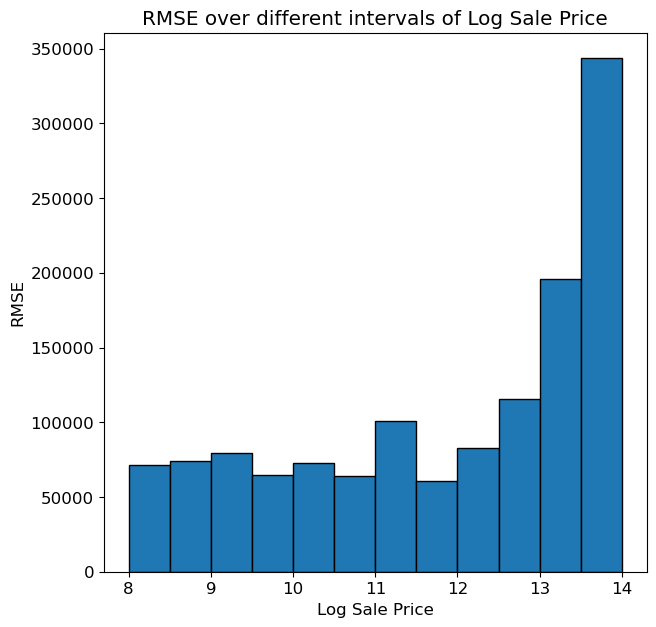

In [98]:
# Run the cell below to generate the plot; no further action is needed
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(X, Y, i, i + 0.5))
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('RMSE');

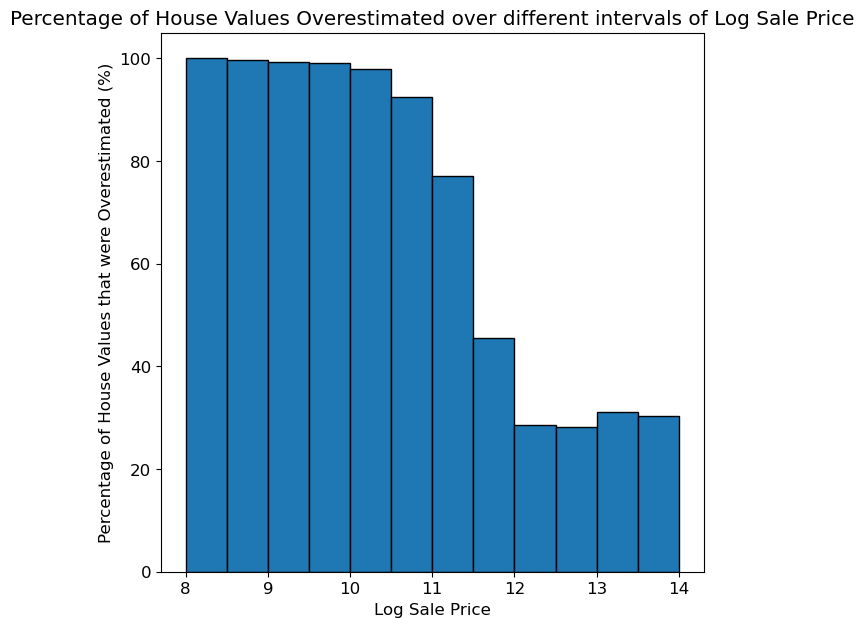

In [99]:
# Run the cell below to generate the plot; no further action is needed
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(X, Y, i, i + 0.5) * 100)
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('Percentage of House Values that were Overestimated (%)');

Explicitly referencing **any ONE** of the plots above (using `props` and `rmses`), explain whether the assessments your model predicts more closely align with scenario C or scenario D that we discussed back in `1b`. Which of the two plots would be more useful in ascertaining whether the assessments tended to result in progressive or regressive taxation? Provide a brief explanation to support your choice of plot. For your reference, the scenarios are also shown below:

    C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
    D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.


C. Lower sale price houses were more overestimated than higher sale price houses.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 7: Evaluating the Model in Context

<br>

---
## Question 7a

When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

Positive Residual: When the residual is positive, it means that the model has undervalued the homeowner's property compared to its actual value. In terms of property taxes, an undervaluation means the homeowner would pay less in property taxes than they should based on the actual value of their home.
Negative Residual: When the residual is negative, it means that the model has overvalued the homeowner's property compared to its actual value. In terms of property taxes, an overvaluation means the homeowner would pay more in property taxes than they should based on the actual value of their home.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<!-- BEGIN QUESTION -->

<br>

---

## Question 7b

Reflecting back on your exploration in Questions 6 and 7a, in your own words, what makes a model's predictions of property values for tax assessment purposes "fair"? 

This question is open-ended and part of your answer may depend upon your specific model; we are looking for thoughtfulness and engagement with the material, not correctness. 

**Hint:** Some guiding questions to reflect on as you answer the question above: What is the relationship between RMSE, accuracy, and fairness as you have defined it? Is a model with a low RMSE necessarily accurate? Is a model with a low RMSE necessarily "fair"? Is there any difference between your answers to the previous two questions? And if so, why?

For tax assessment purposes, a model is considered "fair" when it appraises properties impartially, making sure that no specific set of homeowners face consistent bias.

While a model with a low RMSE may have minimal average errors, it doesn't guarantee uniform accuracy across various property categories.
A low RMSE in a model doesn't equate to fairness. A model might have a low average error but if it consistently misvalues certain types of homes—either undervaluing the pricier ones and overvaluing the cheaper ones, or the reverse—it results in an inequitable tax load for specific homeowners.

<!-- END QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Project A2!

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for submitting the coding portion (the zip from Project A2), the written portion (the PDF from Project A2), and your predictions (the CSV file from Question 5f) to their respective Gradescope portals.** The coding proportion should be submitted to **Project A2 Coding** as a single zip file, the written portion should be submitted to **Project A2 Written** as a single PDF file, and the CSV should be submitted to **Project A2 Test Set Predictions**. When submitting the written portion, **please ensure you select pages appropriately**. 

**PLEASE MAKE SURE YOU SUBMIT TO THE RIGHT ASSIGNMENTS: Project A2 Written AND Project A2 Code, in addition to Project A2 Test Set Predictions**

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

After you have run the cell below and generated the zip file, you can open the PDF <a href='projA2.pdf' download>here</a>.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)